In [1]:
import sys
sys.path.append('../')
from library.datasets import ProstateCancerDataset
from library.train import create_dataloader
from entrypoint import prostate_scoring_function
import matplotlib.pyplot as plt
import torch
from library.models import *

In [2]:
prostate_dir = '../datasets/train_prostate/train/'
random_seed = 24042

In [3]:
val_dataset = ProstateCancerDataset(
                prostate_dir, split_type="val", random_seed=random_seed, input_slice_count=3,
            )

In [4]:
val_loader = create_dataloader(val_dataset, batch_size=4, shuffle=False)

In [5]:
test_dataset = ProstateCancerDataset(prostate_dir, split_type="test", random_seed=random_seed, input_slice_count=3)

In [6]:
test_loader = create_dataloader(test_dataset, batch_size=4, shuffle=False)

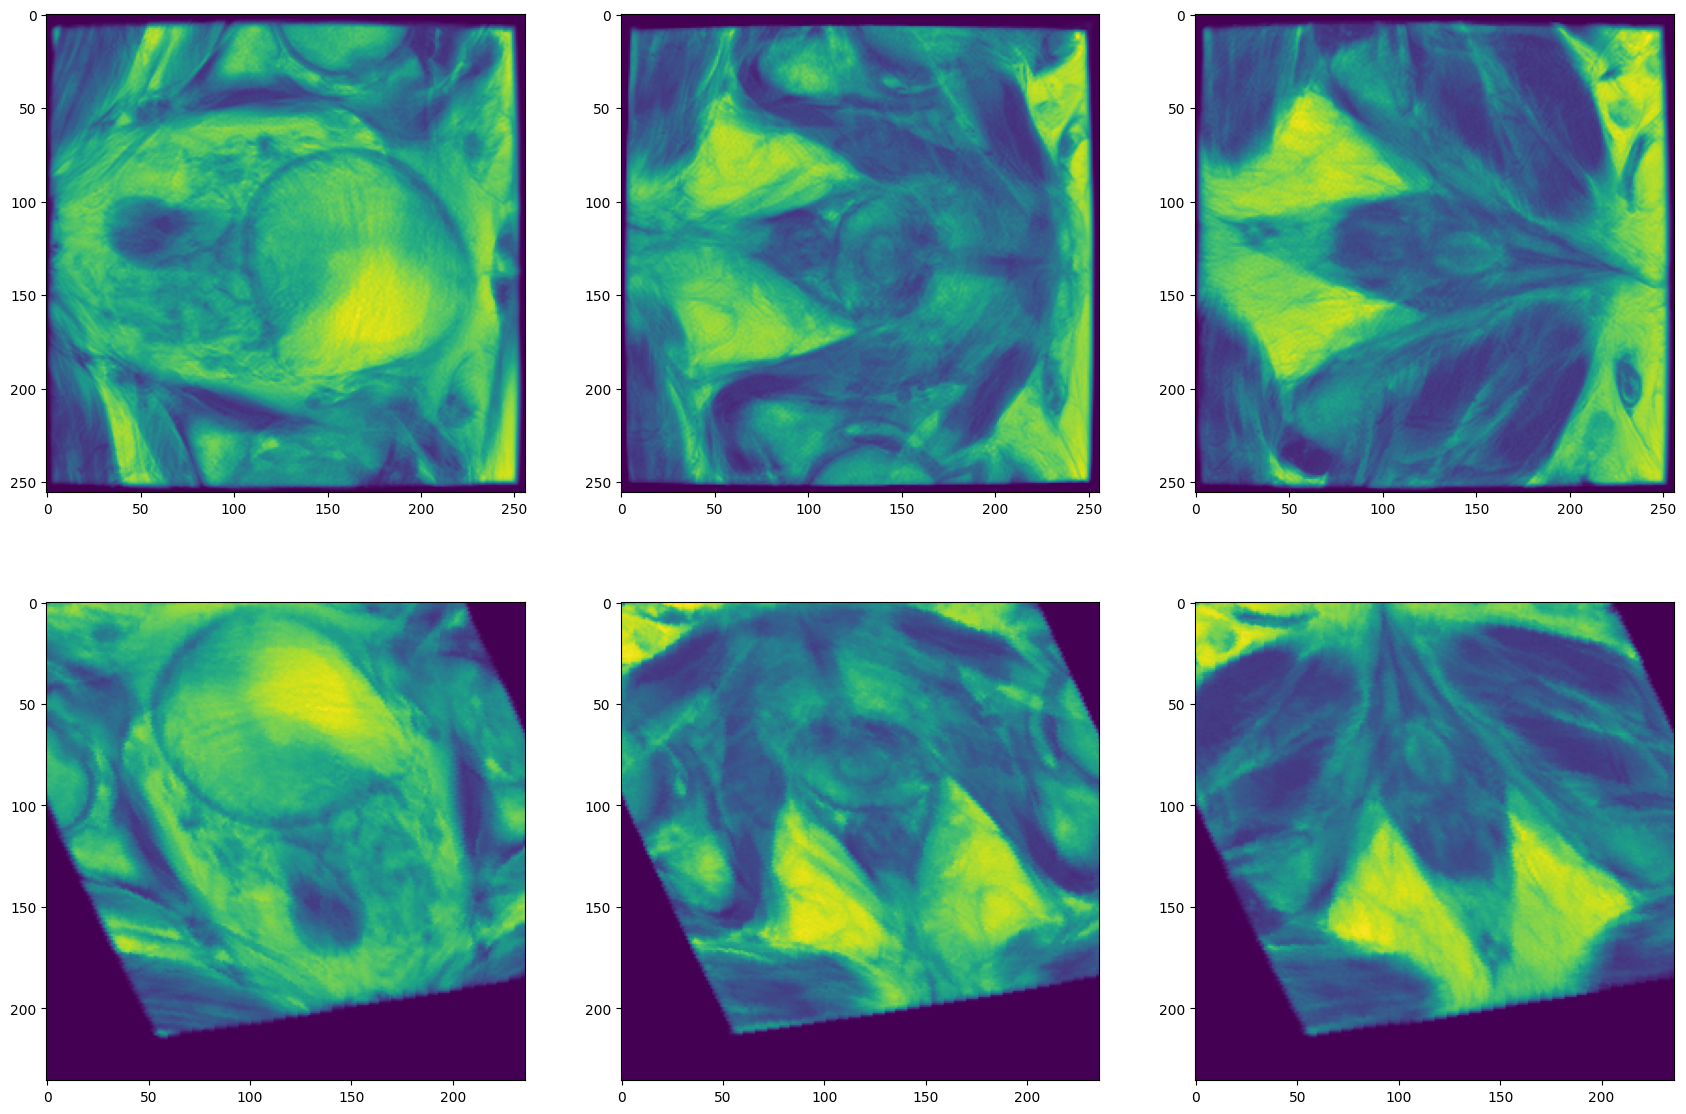

In [7]:
fig, ax = plt.subplots(figsize = (21,14), nrows=2, ncols=3)

ind = 0
(val_image, _,_) = val_dataset[ind]
(test_image, _,_) = test_dataset[ind]
for k in range(3):
    ax[0,k].imshow(val_image[k,:,:].numpy().squeeze())
    ax[1,k].imshow(test_image[k,:,:].numpy().squeeze())

In [8]:
bad_model_acc = ('tuning_exp_training_details/combined_model_raw_metadata/ProstateCombinedModelV1_1Tiny/2023-11-28T02-12-53/'
'3_input_slices/0.01_starting_learning_rate/best_val_acc_ProstateCombinedModelV1_1Tiny.pt')
bad_model_score = ('tuning_exp_training_details/combined_model_raw_metadata/ProstateCombinedModelV1_1Tiny/2023-11-28T02-12-53/'
'3_input_slices/0.01_starting_learning_rate/best_val_score_ProstateCombinedModelV1_1Tiny.pt')
better_model_acc = ("tuning_exp_training_details/pretrained_model_raw_metadata/ProstateCombinedResnet18PretrainedModel/2023-11-27T22-30-46/"
                    "['layer1', 'layer2', 'layer3', 'layer4']_frozen/0.01_starting_learning_rate/best_val_acc_ProstateCombinedResnet18PretrainedModel.pt")
better_model_score = ("tuning_exp_training_details/pretrained_model_raw_metadata/ProstateCombinedResnet18PretrainedModel/2023-11-27T22-30-46/"
                    "['layer1', 'layer2', 'layer3', 'layer4']_frozen/0.01_starting_learning_rate/best_val_score_ProstateCombinedResnet18PretrainedModel.pt")
best_model_score = ("tuning_exp_training_details/pretrained_model_raw_metadata/ProstateCombinedResnet18PretrainedModel/2023-11-27T22-30-46/"
                    "[]_frozen/0.01_starting_learning_rate/best_val_score_ProstateCombinedResnet18PretrainedModel.pt")

3_input_slices_0.01_starting_learning_rate_best_val_score_ProstateCombinedModelV1_1Tiny.pt_results: 
	 val_results: 
		tensor([[3.4838, 1.7212],
        [3.4833, 1.7226],
        [3.4848, 1.7214],
        [3.4782, 1.7272]], grad_fn=<AddmmBackward0>) - 
		tensor([[0],
        [0],
        [0],
        [0]]) 
	 test_results: 
		tensor([[3.8653, 1.8755],
        [3.8550, 1.8684],
        [3.8650, 1.8755],
        [3.8607, 1.8722]], grad_fn=<AddmmBackward0>) - 
		tensor([[0],
        [0],
        [0],
        [0]])

['layer1', 'layer2', 'layer3', 'layer4']_frozen_0.01_starting_learning_rate_best_val_score_ProstateCombinedResnet18PretrainedModel.pt_results: 
	 val_results: 
		tensor([[2.5773, 2.5383],
        [2.3655, 3.3167],
        [2.2416, 2.7525],
        [2.3878, 2.7119]], grad_fn=<AddmmBackward0>) - 
		tensor([[0],
        [1],
        [1],
        [1]]) 
	 test_results: 
		tensor([[2.3326, 3.1617],
        [1.9915, 2.5000],
        [2.1656, 3.8812],
        [3.9369, 1.0779]], grad_f

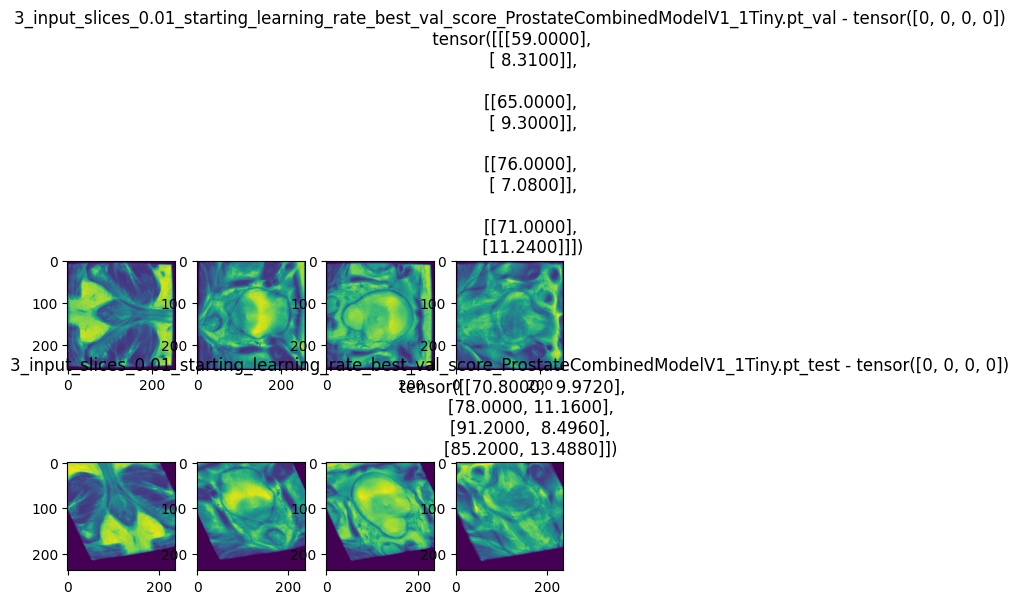

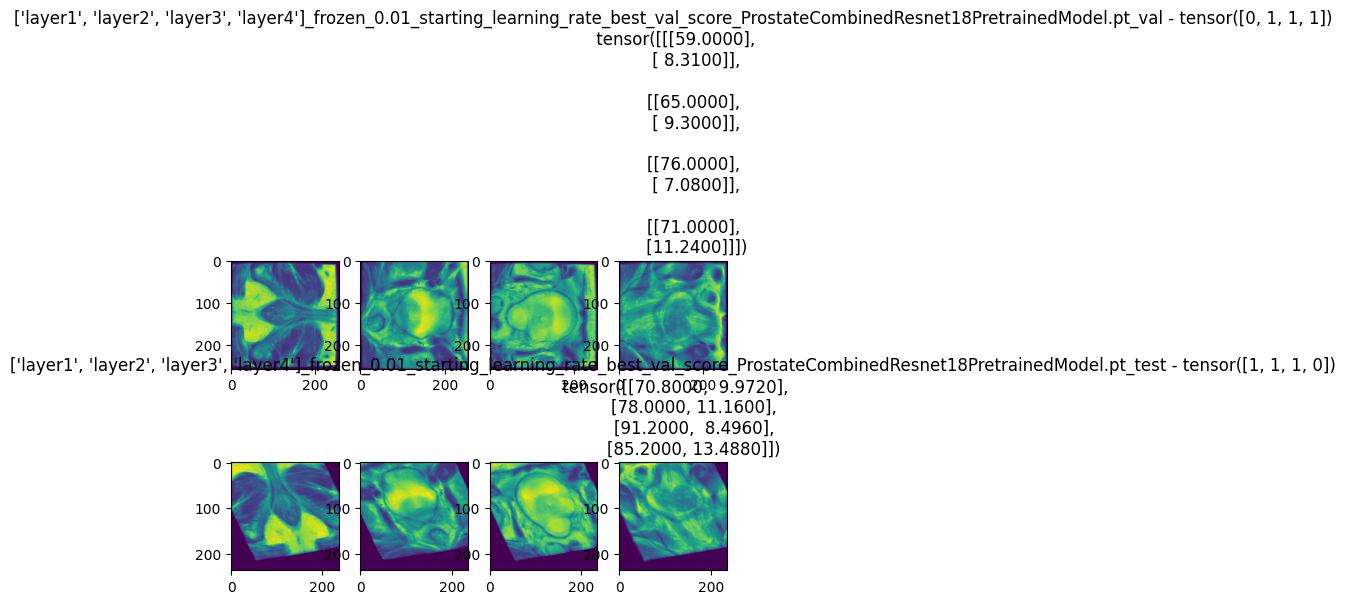

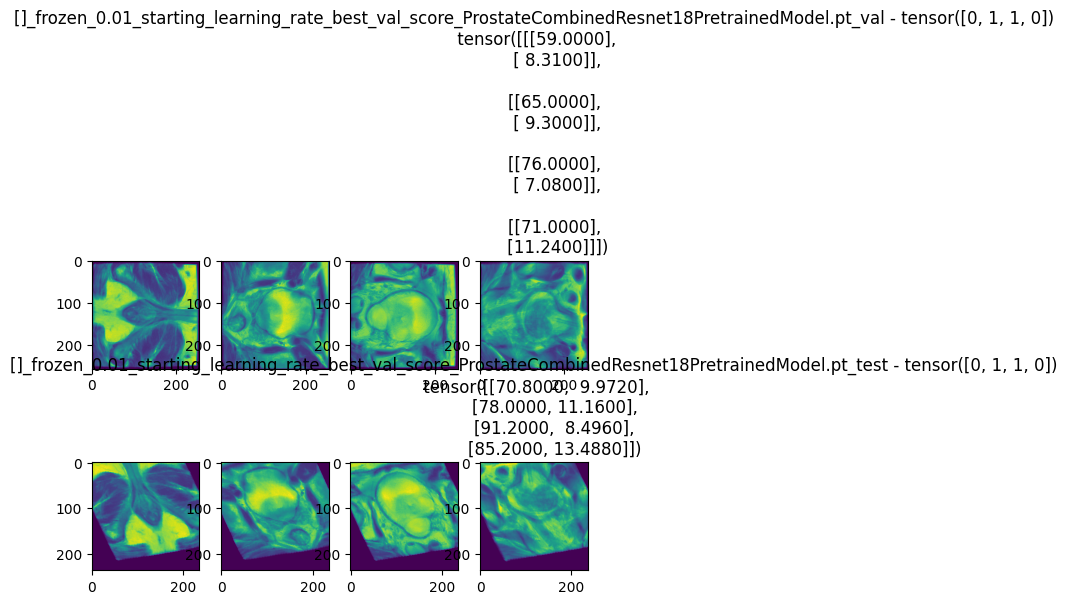

In [15]:
model_list = [
    # bad_model_acc, 
    bad_model_score, 
    # better_model_acc, 
    better_model_score,
    best_model_score,
]

### test metadata augmetation

model_path_to_model = {
    "ProstateCombinedResnet18PretrainedModel.pt": ProstateCombinedResnet18PretrainedModel(),
    "1Tiny.pt": ProstateCombinedModelV1_1Tiny(input_slice_count=3),   
}

ind = 1

for batch_ind, (val_images, val_metadata, val_targets) in enumerate(val_loader):
    val_data = (val_images, val_metadata.squeeze())
    if batch_ind == ind: 
            break
for batch_ind, (test_images, test_metadata, test_targets) in enumerate(test_loader):
    test_metadata =test_metadata.squeeze()
    for k in range(val_images.shape[0]):
        test_metadata[k, 0] *=1.2
        test_metadata[k, 1] *=1.2
        test_data = (test_images, test_metadata)
    if batch_ind == ind: 
            break

for model_path in model_list:
    model = model_path_to_model[model_path.split('_')[-1]]
    model_state_dict = torch.load(f"../{model_path}")
    model.load_state_dict(model_state_dict)
    model.eval()
    val_results = model(val_data)
    test_results = model(test_data)
    model_name = "_".join(model_path.split("/")[-3:])
    print(f"{model_name}_results: \n\t val_results: \n\t\t{val_results} - \n\t\t{val_results.argmax(dim=1, keepdim=True)} \n\t test_results: \n\t\t{test_results} - \n\t\t{test_results.argmax(dim=1, keepdim=True)}\n")
    fig, ax = plt.subplots(nrows=2, ncols=val_images.shape[0])
    for k in range(val_images.shape[0]):
        img = val_images[k,0,:,:].numpy()
        ax[0,k].imshow(img)
    ax[0,k].set_title(f"{model_name}_val - {val_results.argmax(dim=1)}\n {val_metadata}")
    for k in range(test_images.shape[0]):
        img = test_images[k,0,:,:].numpy()
        ax[1,k].imshow(img)
    ax[1,k].set_title(f"{model_name}_test - {test_results.argmax(dim=1)}\n {test_metadata}")
print(val_targets.argmax(dim=1, keepdim=True))